In [1]:
import pandas as pd
from dateutil.relativedelta import relativedelta

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
from scripts.downloader import fetch_all_polls

In [4]:
all_polls = fetch_all_polls(cleanup=True, refresh=False)

In [5]:
all_polls.to_csv('poll_database/poll_database.csv', index=False)
all_polls.to_excel('poll_database/poll_database.xlsx', index=False)
all_polls.to_json('poll_database/poll_database.json', index=False, orient='split')

In [6]:
display_columns = ['date_concluded', 'pollster', 'conservative', 'labour', 'liberal_democrat', 'lead']

In [7]:
all_polls.query("pollster=='Survation' ")[display_columns]

,date_concluded,pollster,conservative,labour,liberal_democrat,lead
6,2022-01-25,Survation,35.0,40.0,10.0,lab+5.0
11,2022-01-17,Survation,33.0,43.0,10.0,lab+10.0
37,2021-12-14,Survation,34.0,40.0,8.0,lab+6.0
41,2021-12-11,Survation,32.0,39.0,9.0,lab+7.0
47,2021-12-09,Survation,34.0,40.0,10.0,lab+6.0
...,...,...,...,...,...,...
2148,2013-05-24,Survation,24.0,35.0,10.0,lab+11.0
2153,2013-05-18,Survation,24.0,35.0,11.0,lab+11.0
2175,2013-04-28,Survation,29.0,36.0,12.0,lab+7.0
2269,2013-01-25,Survation,31.0,38.0,10.0,lab+7.0


In [8]:
all_polls.query("pollster=='Survation' and lead_value>=10 and labour>conservative")[display_columns]

,date_concluded,pollster,conservative,labour,liberal_democrat,lead
11,2022-01-17,Survation,33.0,43.0,10.0,lab+10.0
1983,2013-10-11,Survation,27.0,37.0,11.0,lab+10.0
2105,2013-07-03,Survation,23.0,36.0,10.0,lab+13.0
2140,2013-05-30,Survation,25.0,36.0,10.0,lab+11.0
2148,2013-05-24,Survation,24.0,35.0,10.0,lab+11.0
2153,2013-05-18,Survation,24.0,35.0,11.0,lab+11.0


In [9]:
all_polls.query("pollster=='Survation' and labour >= 43")[display_columns]

,date_concluded,pollster,conservative,labour,liberal_democrat,lead
11,2022-01-17,Survation,33.0,43.0,10.0,lab+10.0
834,2018-03-08,Survation,37.0,44.0,9.0,lab+7.0
848,2018-01-29,Survation,40.0,43.0,8.0,lab+3.0
863,2017-12-01,Survation,37.0,45.0,6.0,lab+8.0
882,2017-10-05,Survation,38.0,44.0,7.0,lab+6.0
895,2017-09-01,Survation,38.0,43.0,7.0,lab+5.0
914,2017-06-17,Survation,41.0,44.0,6.0,lab+3.0
915,2017-06-10,Survation,39.0,45.0,7.0,lab+6.0


In [10]:
all_polls.query("pollster=='Deltapoll' and lead_value>=5 and labour>conservative")[display_columns]

,date_concluded,pollster,conservative,labour,liberal_democrat,lead
3,2022-01-27,Deltapoll,32.0,42.0,10.0,lab+10.0
14,2022-01-16,Deltapoll,32.0,41.0,11.0,lab+9.0
27,2021-12-30,Deltapoll,35.0,40.0,10.0,lab+5.0
664,2019-03-30,Deltapoll,36.0,41.0,7.0,lab+5.0
783,2018-07-14,Deltapoll,37.0,42.0,7.0,lab+5.0


In [11]:
all_polls.query("pollster=='Savanta ComRes' and lead_value>=10 and labour>conservative")[display_columns]

,date_concluded,pollster,conservative,labour,liberal_democrat,lead
1,2022-01-30,Savanta ComRes,33.0,44.0,9.0,lab+11.0
15,2022-01-14,Savanta ComRes,32.0,42.0,11.0,lab+10.0
654,2019-04-16,Savanta ComRes,23.0,33.0,7.0,lab+10.0
2146,2013-05-24,Savanta ComRes,26.0,37.0,9.0,lab+11.0
2207,2013-03-24,Savanta ComRes,28.0,38.0,12.0,lab+10.0
2237,2013-02-24,Savanta ComRes,31.0,43.0,8.0,lab+12.0
2304,2012-12-16,Savanta ComRes,28.0,39.0,9.0,lab+11.0
2472,2012-06-15,Savanta ComRes,32.0,42.0,9.0,lab+10.0
2547,2012-03-26,Savanta ComRes,33.0,43.0,11.0,lab+10.0


In [12]:
all_polls.query("labour>=44")[display_columns]

,date_concluded,pollster,conservative,labour,liberal_democrat,lead
1,2022-01-30,Savanta ComRes,33.0,44.0,9.0,lab+11.0
834,2018-03-08,Survation,37.0,44.0,9.0,lab+7.0
863,2017-12-01,Survation,37.0,45.0,6.0,lab+8.0
882,2017-10-05,Survation,38.0,44.0,7.0,lab+6.0
890,2017-09-18,Ipsos MORI,40.0,44.0,9.0,lab+4.0
...,...,...,...,...,...,...
5663,1971-01-17,Gallup,42.5,47.0,NaN,lab+4.5
5664,1970-12-13,Gallup,46.0,44.5,NaN,con+1.5
5665,1970-11-15,Gallup,43.5,48.0,NaN,lab+4.5
5666,1970-10-18,Gallup,46.5,46.5,NaN,Tie


In [13]:
all_polls.query("labour>=50")[display_columns+['green']]

,date_concluded,pollster,conservative,labour,liberal_democrat,lead,green
3854,2001-06-02,Ipsos MORI,27.0,50.0,17.0,lab+23.0,NaN
3855,2001-06-01,Ipsos MORI,27.0,50.0,17.0,lab+23.0,NaN
3865,2001-05-22,Ipsos MORI,27.0,52.0,16.0,lab+25.0,NaN
3868,2001-05-20,Gallup,25.0,55.0,14.0,lab+30.0,NaN
3871,2001-05-15,Ipsos MORI,28.0,54.0,12.0,lab+26.0,NaN
...,...,...,...,...,...,...,...
5654,1971-09-20,Gallup,35.0,54.0,NaN,lab+19.0,NaN
5656,1971-07-12,Gallup,33.5,55.0,NaN,lab+21.5,NaN
5657,1971-06-13,Gallup,36.0,54.0,NaN,lab+18.0,NaN
5658,1971-05-16,Gallup,38.0,50.0,NaN,lab+12.0,NaN


In [14]:
all_polls.query("lead_value >= 10 and labour>conservative")[display_columns]

,date_concluded,pollster,conservative,labour,liberal_democrat,lead
1,2022-01-30,Savanta ComRes,33.0,44.0,9.0,lab+11.0
3,2022-01-27,Deltapoll,32.0,42.0,10.0,lab+10.0
11,2022-01-17,Survation,33.0,43.0,10.0,lab+10.0
12,2022-01-17,Redfield & Wilton Strategies,30.0,43.0,9.0,lab+13.0
15,2022-01-14,Savanta ComRes,32.0,42.0,11.0,lab+10.0
...,...,...,...,...,...,...
5654,1971-09-20,Gallup,35.0,54.0,NaN,lab+19.0
5656,1971-07-12,Gallup,33.5,55.0,NaN,lab+21.5
5657,1971-06-13,Gallup,36.0,54.0,NaN,lab+18.0
5658,1971-05-16,Gallup,38.0,50.0,NaN,lab+12.0


In [15]:
all_polls.query("labour >= 42")[display_columns]

,date_concluded,pollster,conservative,labour,liberal_democrat,lead
1,2022-01-30,Savanta ComRes,33.0,44.0,9.0,lab+11.0
3,2022-01-27,Deltapoll,32.0,42.0,10.0,lab+10.0
11,2022-01-17,Survation,33.0,43.0,10.0,lab+10.0
12,2022-01-17,Redfield & Wilton Strategies,30.0,43.0,9.0,lab+13.0
15,2022-01-14,Savanta ComRes,32.0,42.0,11.0,lab+10.0
...,...,...,...,...,...,...
5665,1970-11-15,Gallup,43.5,48.0,NaN,lab+4.5
5666,1970-10-18,Gallup,46.5,46.5,NaN,Tie
5667,1970-09-13,Gallup,46.5,44.0,NaN,con+2.5
5668,1970-08-16,Gallup,47.0,43.5,NaN,con+3.5


In [16]:
all_polls.query("pollster == 'FocalData'")[display_columns]

,date_concluded,pollster,conservative,labour,liberal_democrat,lead
20,2022-01-13,FocalData,33.0,42.0,11.0,lab+9.0
29,2021-12-21,FocalData,34.0,41.0,9.0,lab+7.0
30,2021-12-21,FocalData,32.0,40.0,10.0,lab+8.0
48,2021-12-09,FocalData,33.0,41.0,7.0,lab+8.0
206,2021-04-30,FocalData,40.0,39.0,6.0,con+1.0
290,2020-12-29,FocalData,36.0,38.0,9.0,lab+2.0
467,2019-12-10,FocalData,42.0,34.0,14.0,con+8.0


In [17]:
all_polls.query("labour >= 50")[display_columns]

,date_concluded,pollster,conservative,labour,liberal_democrat,lead
3854,2001-06-02,Ipsos MORI,27.0,50.0,17.0,lab+23.0
3855,2001-06-01,Ipsos MORI,27.0,50.0,17.0,lab+23.0
3865,2001-05-22,Ipsos MORI,27.0,52.0,16.0,lab+25.0
3868,2001-05-20,Gallup,25.0,55.0,14.0,lab+30.0
3871,2001-05-15,Ipsos MORI,28.0,54.0,12.0,lab+26.0
...,...,...,...,...,...,...
5654,1971-09-20,Gallup,35.0,54.0,NaN,lab+19.0
5656,1971-07-12,Gallup,33.5,55.0,NaN,lab+21.5
5657,1971-06-13,Gallup,36.0,54.0,NaN,lab+18.0
5658,1971-05-16,Gallup,38.0,50.0,NaN,lab+12.0


In [18]:
#all_polls.query("pollster == 'YouGov' and conservative <31")[display_columns]

In [19]:
most_recent_date = all_polls.iloc[0].date_concluded
one_year_polls = all_polls[
    all_polls['date_concluded'] >= (most_recent_date + relativedelta(months=-12)).replace(day=1)].copy()

In [20]:
pollsters_latest = pd.DataFrame()
for pollster in one_year_polls.pollster.unique():
    pollster_data = one_year_polls.query(f'pollster == "{pollster}"')
    latest_poll = pollster_data.iloc[0]
    pollsters_latest = pollsters_latest.append(latest_poll)

In [21]:
top_five = {'Ipsos MORI': 100,
            'Opinium': 79,
            'YouGov': 77,
            'Kantar Public': 69,
            'Number Cruncher Politics': 61,
            'Survation': 59,
            'Panelbase': 57,
            'Deltapoll': 46,
            'BMG Research': 44,
            'FocalData': 39,
            'ICM Research': 35,
            'Savanta ComRes': 34,
            'Find Out Now': 34,
            'Redfield & Wilton Strategies': 34,
            }

top_two = {'Ipsos MORI': 100,
           'Survation': 85,
           'Kantar Public': 85,
           'Panelbase': 74,
           'Number Cruncher Politics': 71,
           'Opinium': 71,
           'YouGov': 67,
           'Deltapoll': 50,
           'FocalData': 42,
           'BMG Research': 39,
           'Savanta ComRes': 29,
           'ICM Research': 27,
           'Find Out Now': 34,
           'Redfield & Wilton Strategies': 34,
           }

In [22]:
recency_weights = {
    -1: 100,
    7: 100,
    15: 70,
    30: 5,
    90: 0
}


def get_recency_weight(date_concluded, current_date, return_category=False):
    days_since_poll = (current_date - date_concluded).days
    days_start_of_range = weight_start_of_range = 0
    category = 0
    for day, weight in recency_weights.items():
        category += 1
        if days_since_poll > day:
            days_start_of_range = day
            weight_start_of_range = weight
        else:
            percent_through_range = (days_since_poll - days_start_of_range)/(day - days_start_of_range)
            full_weight = weight_start_of_range - ((weight_start_of_range - weight)*percent_through_range)
            if return_category:
                return category - 2
            else:
                return full_weight
    if return_category:
        return category - 1
    else:
        return 0


In [23]:
def get_pollster_weight(pollster):
    if pollster not in top_two:
        return 0
    top_five_score = top_five[pollster]
    top_two_score = top_two[pollster]
    pollster_w = (3*top_two_score + 2*top_five_score + 100)/6
    return pollster_w


In [24]:
for pollster in one_year_polls.pollster.unique():
    print(f' {pollster:30s}: {get_pollster_weight(pollster):.1f}')

 Redfield & Wilton Strategies  : 45.0
 Savanta ComRes                : 42.5
 Opinium                       : 78.5
 Deltapoll                     : 57.0
 YouGov                        : 75.8
 Ipsos MORI                    : 100.0
 Survation                     : 78.8
 Kantar Public                 : 82.2
 Find Out Now                  : 45.0
 FocalData                     : 50.7
 Panelbase                     : 72.7
 Number Cruncher Politics      : 72.5
 BMG Research                  : 50.8


In [25]:
from scripts.constants import major_parties

In [26]:
pollsters_latest['recency_weight'] = pollsters_latest['date_concluded'].apply(get_recency_weight,
                                                                              current_date=most_recent_date)
pollsters_latest['pollster_weight'] = pollsters_latest['pollster'].apply(get_pollster_weight)
pollsters_latest['poll_weight'] = pollsters_latest['pollster_weight']*(pollsters_latest['recency_weight']/100)

In [27]:
current_average = pd.DataFrame(columns=major_parties + ['lead'], index=['Polling Average'])
lead_party = ''
max_vote_share = 0
second_vote_share = 0
for party in major_parties:
    party_vote_share = pollsters_latest[party].dot(pollsters_latest['poll_weight'])/pollsters_latest[
        'poll_weight'].sum()
    if party_vote_share > max_vote_share:
        second_vote_share = max_vote_share
        max_vote_share = party_vote_share
        lead_party = party
    else:
        if party_vote_share > second_vote_share:
            second_vote_share = party_vote_share
    current_average.loc['Polling Average', party] = party_vote_share
    #current_average.loc['Polling Average', party] = f'{party_vote_share:.1f}%'
#current_average.loc['Polling Average', 'lead'] = f'{lead_party:.3s}+{max_vote_share - second_vote_share:.1f}%'
current_average.loc['Polling Average', 'lead_value'] = max_vote_share - second_vote_share


In [28]:
one_year_polls['poll_month'] = one_year_polls['date_concluded'].apply(lambda x: x.replace(day=1))

In [29]:
pollster_monthly_summary = one_year_polls.groupby(['poll_month', 'pollster'])[major_parties].agg(['mean', 'count'])
pollster_monthly_summary.columns = [x if i == 0 else f'count{major_parties.index(x)}' for x in major_parties for i in
                                    range(0, 2)]
pollster_monthly_summary.drop(columns=[f'count{major_parties.index(x)}' for x in major_parties][1:], inplace=True)
pollster_monthly_summary.rename(columns={"count0": "count"}, inplace=True)

agg_info = {x: ['mean'] for x in major_parties}
agg_info['count'] = ['count', 'sum']
monthly_summary = pollster_monthly_summary.reset_index().groupby(['poll_month']).agg(agg_info)
monthly_summary.columns = major_parties + ['pollster_count', 'poll_count']

In [30]:
from scripts.functions import format_lead

monthly_summary[['lead', 'lead_value']] = monthly_summary.apply(format_lead, axis=1, result_type='expand')

In [31]:
display(pollsters_latest.sort_values(by='poll_weight', ascending=False)[display_columns])
display(current_average)
display(monthly_summary.iloc[:0:-1])

,date_concluded,pollster,conservative,labour,liberal_democrat,lead
5,2022-01-25,Ipsos MORI,31.0,40.0,13.0,lab+9.0
8,2022-01-24,Kantar Public,34.0,38.0,11.0,lab+4.0
6,2022-01-25,Survation,35.0,40.0,10.0,lab+5.0
2,2022-01-28,Opinium,34.0,39.0,9.0,lab+5.0
4,2022-01-27,YouGov,32.0,38.0,11.0,lab+6.0
3,2022-01-27,Deltapoll,32.0,42.0,10.0,lab+10.0
0,2022-01-31,Redfield & Wilton Strategies,33.0,40.0,11.0,lab+7.0
1,2022-01-30,Savanta ComRes,33.0,44.0,9.0,lab+11.0
20,2022-01-13,FocalData,33.0,42.0,11.0,lab+9.0
18,2022-01-13,Find Out Now,27.0,41.0,11.0,lab+14.0


,conservative,labour,liberal_democrat,lead,lead_value
Polling Average,32.734718,39.954307,10.707679,NaN,7.219589


,conservative,labour,liberal_democrat,pollster_count,poll_count,lead,lead_value
poll_month,,,,,,,
2022-01-01,32.063333,40.316667,10.803333,10,27,lab+8.3,8.253333
2021-12-01,33.633333,38.475000,10.075000,10,29,lab+4.8,4.841667
2021-11-01,37.066667,36.575000,9.250000,10,23,con+0.5,0.491667
2021-10-01,39.268750,34.645833,8.289583,8,20,con+4.6,4.622917
2021-09-01,39.843333,34.331667,9.376667,10,23,con+5.5,5.511667
2021-08-01,40.016667,33.316667,10.400000,6,18,con+6.7,6.700000
2021-07-01,41.787037,33.601852,9.444444,9,21,con+8.2,8.185185
2021-06-01,43.477778,33.455556,7.566667,9,24,con+10.0,10.022222
2021-05-01,43.468750,32.812500,8.062500,8,21,con+10.7,10.656250


In [32]:
from html2image import Html2Image

hti = Html2Image()

In [33]:



def result_to_opacity(result, range_min, range_max):
    result_range = range_max - range_min
    result_percent = (result - range_min)/result_range
    result_256 = int(result_percent*255)
    return f'{result_256:02x}'


def add_background_colour_to_cells(df, lead_only=False):
    from scripts.constants import party_colors, major_parties
    background_df = df.copy()
    max_party_lead = background_df['lead_value'].max()

    for party in major_parties:
        color = party_colors[party]
        party_max = background_df[party].max()
        party_min = background_df[party].min() - 0.5
        if not lead_only:
            background_df[party] = background_df[party].apply(
                lambda x: f'background-color: {color}{result_to_opacity(x, party_min, party_max)}'
            )
        else:
            background_df[party] = ''
        party_in_lead_mask = df[party] == df[major_parties].max(axis=1)
        background_df.loc[party_in_lead_mask, 'lead_value'] = df['lead_value'].apply(
            lambda x: f'background-color: {color}{result_to_opacity(x, 0, max_party_lead)}'
        )

    if 'date_concluded' in background_df.columns:
        background_df['date_concluded'] = background_df['date_concluded'].apply(get_recency_weight,
                                                                                current_date=most_recent_date)
        background_df['date_concluded'] = background_df['date_concluded'].apply(
            lambda x: f'background-color: #A9D08E{result_to_opacity(x, 0, 100)}'
        )

    for column in background_df.columns:
        if not (column in major_parties or column in ['lead_value', 'date_concluded']):
            background_df[column] = ''
    return background_df

In [34]:
def polls_to_html(dataframe, title, highlight_party_columns=True, precision=0):
    dataframe.index.name = 'id'
    table_id = '_'.join(title.split(' ')).lower()

    from pandas.io.formats.style import Styler
    #styler = dataframe.style
    styler = Styler(dataframe, uuid=table_id, cell_ids=True)

    styler.apply(add_background_colour_to_cells, axis=None,
                                   lead_only=not (highlight_party_columns))\

    styler.format({
        "pollster": lambda x: f"{x}",
        "pollster_count": lambda x: f"{x}",
        "poll_count": lambda x: f"{x}",
        "conservative": lambda x: f"{x:.{precision}f}%",
        "labour": lambda x: f"{x:.{precision}f}%",
        "liberal_democrat": lambda x: f"{x:.{precision}f}%",
        "lead_value": lambda x: f"{x:.{precision}f}%",
        'date_concluded': lambda x: f"{x:%d-%b}",
        'poll_month': lambda x: f"{x:%b-%y}",
        'poll_weight': lambda x: f"{x:.0f}",
    })

    styler.set_table_attributes(f'id="{table_id}"')
    styler.hide_index()

    # classes = pd.DataFrame([['_'.join(x.split(' ')).lower() for x in dataframe.columns]]
    #                        , index=dataframe.index, columns=dataframe.columns)
    #
    # styler.set_td_classes(classes)

    #styler.set_caption(title)
    styler.set_properties(**{'min-width': '10px', 'font-size': '12pt', 'text-align': 'center'})

    caption_format = {'selector': 'caption',
                      'props': [('text-align', 'center'), ('font-size', '20pt'), ('color', 'black'),
                                ('padding-bottom', '15')]}
    all_cells = {'selector': '', 'props': [('margin', '0 auto'), ('width', '100%')]}
    date_col = {'selector': '.col0', 'props': [('text-align', 'left')]}

    styles = [all_cells, date_col, caption_format]

    if 'poll_weight' in dataframe.columns:
        styles.append({'selector': '.col2', 'props': [('color', '#AAA')]})

    df_as_html = styler.set_table_styles(styles).render()

    for col in range(0,len(dataframe.columns)):
        df_as_html = df_as_html.replace(f'col{col}',dataframe.columns[col])


    df_as_html = (df_as_html
                  .replace('>poll_count', '>Polls')
                  .replace('>pollster_count', '>Pollsters')
                  .replace('>conservative', '>Conservatives')
                  .replace('>labour', '>Labour')
                  .replace('>liberal_democrat', '>Lib Dem')
                  .replace('>lead_value', '>Lead')
                  .replace('>date_concluded', '>Date')
                  .replace('>poll_month', '>Month')
                  .replace('>pollster', '>Pollster')
                  .replace('>poll_weight', '>w')
                  )
    return df_as_html

In [35]:
display_columns = ['date_concluded', 'pollster', 'conservative', 'labour', 'liberal_democrat', 'lead_value']
top_25_html = polls_to_html(all_polls[display_columns][0:25], title='Last 25 Polls')

In [36]:
display_columns = ['pollster', 'date_concluded', 'poll_weight', 'conservative', 'labour', 'liberal_democrat',
                   'lead_value']
df = pollsters_latest.sort_values(by='poll_weight', ascending=False)[display_columns]
pollsters_recent = polls_to_html(df, title='Latest Polls', highlight_party_columns=False)

In [37]:
display_columns = ['poll_month', 'pollster_count', 'poll_count', 'conservative', 'labour', 'liberal_democrat',
                   'lead_value']
df = monthly_summary.reset_index()[display_columns].iloc[:0:-1]
monthly_averages = polls_to_html(df, title='Monthly Poll Average', highlight_party_columns=True, precision=1)

In [38]:
polling_average = polls_to_html(current_average[['conservative', 'labour', 'liberal_democrat', 'lead_value']],
                                title='Polling Average', highlight_party_columns=False, precision=1)

In [39]:

css = "body {background: white;}"
# hti.screenshot(html_str=top_25_html, css_str=css, save_as='tmp.png', size=(800, 650))
# hti.screenshot(html_str=pollsters_recent, css_str=css, save_as='tmp.png', size=(700, 400))

In [40]:
with open('html_outputs/top_25.html', 'w') as f:
    f.write(top_25_html)
with open('html_outputs/pollsters_recent.html', 'w') as f:
    f.write(pollsters_recent)
with open('html_outputs/monthly_averages.html', 'w') as f:
    f.write(monthly_averages)
with open('html_outputs/polling_average.html', 'w') as f:
    f.write(polling_average)

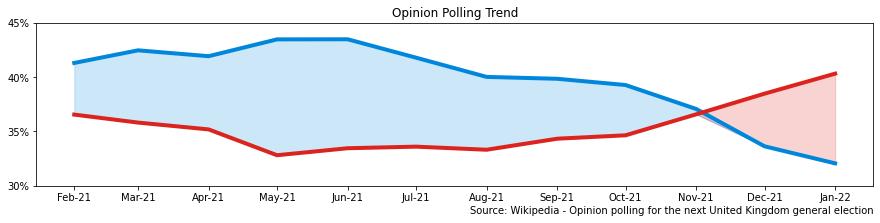

In [41]:
from scripts.constants import party_colors, major_parties
import matplotlib.pyplot as plt
from numpy import arange

fig = plt.figure(figsize=(15, 3))
fig.set_facecolor('white')
ax = plt.gca()

# monthly_summary[major_parties[:2]][1:].plot(
#     ax=ax,
#     ylim=[30, 45],
#     color=party_colors,
#     linewidth=3
# )
for party in major_parties[:2]:
    plt.plot_date(
        x=monthly_summary.index[1:],
        y= monthly_summary[party][1:],
        fmt='-',
        color=party_colors[party],
        linewidth=4)

    ax.fill_between(monthly_summary.index[1:], monthly_summary[party][1:], monthly_summary[major_parties[:2]].min(axis=1)[1:], color=party_colors[party], alpha=0.2)
ax.set_yticks(arange(30, 46, 5), minor=False)
major_locator = plt.matplotlib.dates.DayLocator([1])
major_fmt = plt.matplotlib.dates.DateFormatter('%b-%y')

ax.xaxis.set_major_locator(major_locator)
ax.xaxis.set_major_formatter(major_fmt)

ax.yaxis.set_major_formatter(plt.matplotlib.ticker.FuncFormatter(lambda x, p: f'{x/100:.0%}'))

plot_title = 'Opinion Polling Trend'
plt.title(plot_title)

source = 'Source: Wikipedia - Opinion polling for the next United Kingdom general election'
plt.annotate(source, (1, 0), (0, -20), xycoords='axes fraction', textcoords='offset points', va='top', ha='right')
fig.savefig('html_outputs/monthly_trend.png', bbox_inches = 'tight', pad_inches = 0.2)

In [42]:
monthly_summary

,conservative,labour,liberal_democrat,pollster_count,poll_count,lead,lead_value
poll_month,,,,,,,
2021-01-01,39.892857,38.214286,7.297619,7,17,con+1.7,1.678571
2021-02-01,41.300000,36.550000,7.125000,10,21,con+4.8,4.750000
2021-03-01,42.460000,35.815000,7.323333,10,20,con+6.6,6.645000
2021-04-01,41.921212,35.186364,7.448485,11,25,con+6.7,6.734848
2021-05-01,43.468750,32.812500,8.062500,8,21,con+10.7,10.656250
2021-06-01,43.477778,33.455556,7.566667,9,24,con+10.0,10.022222
2021-07-01,41.787037,33.601852,9.444444,9,21,con+8.2,8.185185
2021-08-01,40.016667,33.316667,10.400000,6,18,con+6.7,6.700000
2021-09-01,39.843333,34.331667,9.376667,10,23,con+5.5,5.511667


In [43]:
import datetime

<AxesSubplot:xlabel='date_concluded'>

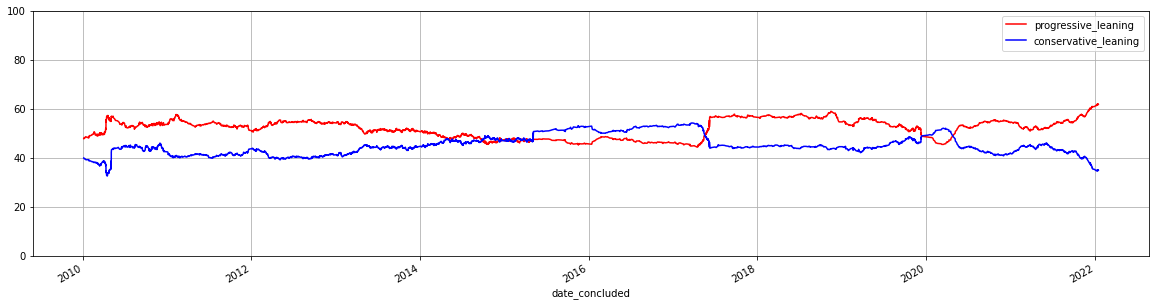

In [44]:
all_polls['progressive_leaning']=all_polls[['labour', 'liberal_democrat', 'alliance', 'change_uk', 'green', 'liberal', 'plaid_cymru', 'scottish_national_party', 'social_democratic_party']].sum(axis=1)
all_polls['conservative_leaning']=all_polls[['conservative', 'brexit_party', 'reform_uk','united_kingdom_independence_party', 'reclaim_party']].sum(axis=1)
(all_polls
 .set_index('date_concluded')
 .rolling(window=15).mean()
 .loc[:datetime.date(2010,1,1)]
 [['progressive_leaning','conservative_leaning']]
 .plot(
    color=['r','b']
    ,figsize=[20,5]
    ,grid='y'
    ,ylim=[0,100]
)
)

In [45]:
all_polls.set_index('date_concluded').rolling(window=10).mean()

,conservative,labour,liberal_democrat,alliance,brexit_party,change_uk,green,liberal,plaid_cymru,reform_uk,scottish_national_party,social_democratic_party,united_kingdom_independence_party,reclaim_party,others,lead_value,progressive_leaning,conservative_leaning
date_concluded,,,,,,,,,,,,,,,,,,
2022-01-31,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2022-01-30,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2022-01-28,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2022-01-27,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2022-01-27,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1970-11-15,40.80,49.15,NaN,NaN,NaN,NaN,NaN,7.85,NaN,NaN,NaN,NaN,NaN,NaN,NaN,8.65,57.00,40.80
1970-10-18,42.10,48.30,NaN,NaN,NaN,NaN,NaN,7.65,NaN,NaN,NaN,NaN,NaN,NaN,NaN,6.50,55.95,42.10
1970-09-13,43.15,47.30,NaN,NaN,NaN,NaN,NaN,7.65,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4.95,54.95,43.15


In [46]:
all_polls.set_index('date_concluded').loc[datetime.date(2020,1,1):]

,date_started,pollster,client,area,sample_size,conservative,labour,liberal_democrat,alliance,brexit_party,...,reform_uk,scottish_national_party,social_democratic_party,united_kingdom_independence_party,reclaim_party,others,lead,lead_value,progressive_leaning,conservative_leaning
date_concluded,,,,,,,,,,,,,,,,,,,,,
2019-12-12,2019-12-12,General Election,NaN,GB,–,44.7,33.0,11.8,NaN,2.1,...,NaN,4.0,NaN,0.1,NaN,1.0,con+11.7,11.7,52.1,46.9
2019-12-12,2019-12-12,General Election,2019 general election,GB,–,44.7,32.9,11.8,NaN,2.1,...,NaN,4.0,NaN,NaN,NaN,NaN,con+11.8,11.8,51.5,46.8
2019-12-12,2019-12-12,General Election,2019 general election,UK,–,43.6,32.1,11.6,NaN,2.0,...,NaN,3.9,NaN,NaN,NaN,NaN,con+11.5,11.5,50.3,45.6
2019-12-11,2019-12-10,Survation,NaN,GB,2395,45.0,34.0,9.0,NaN,3.0,...,NaN,4.0,NaN,NaN,NaN,2.0,con+11.0,11.0,51.0,48.0
2019-12-11,2019-12-10,Panelbase,NaN,GB,3174,43.0,34.0,11.0,NaN,4.0,...,NaN,4.0,NaN,NaN,NaN,3.0,con+9.0,9.0,52.0,47.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1970-11-15,1970-11-15,Gallup,The Daily Telegraph,NaN,NaN,43.5,48.0,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,lab+4.5,4.5,54.5,43.5
1970-10-18,1970-10-18,Gallup,The Daily Telegraph,NaN,NaN,46.5,46.5,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,Tie,0.0,53.0,46.5
1970-09-13,1970-09-13,Gallup,The Daily Telegraph,NaN,NaN,46.5,44.0,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,con+2.5,2.5,52.0,46.5


In [47]:
one_year_polls['poll_month'] = one_year_polls['date_concluded'].apply(lambda x: x.replace(day=1))

In [48]:
kantar_polls = all_polls.query('pollster == "Kantar Public" and date_concluded> "2019-01-01"').copy()
other_polls = all_polls.query('pollster != "Kantar Public" and date_concluded> "2019-01-01"').copy()

In [49]:
kantar_polls['poll_month'] = kantar_polls['date_concluded'].apply(lambda x: x.replace(day=1))
other_polls['poll_month'] = other_polls['date_concluded'].apply(lambda x: x.replace(day=1))

In [50]:
other_pollster_monthly_summary = other_polls.groupby(['poll_month', 'pollster'])[major_parties].agg(['mean', 'count'])
other_pollster_monthly_summary.columns = [x if i == 0 else f'count{major_parties.index(x)}' for x in major_parties for i in
                                    range(0, 2)]
other_pollster_monthly_summary.drop(columns=[f'count{major_parties.index(x)}' for x in major_parties][1:], inplace=True)
other_pollster_monthly_summary.rename(columns={"count0": "count"}, inplace=True)

agg_info = {x: ['mean'] for x in major_parties}
agg_info['count'] = ['count', 'sum']
other_monthly_summary = other_pollster_monthly_summary.reset_index().groupby(['poll_month']).agg(agg_info)
other_monthly_summary.columns = major_parties + ['pollster_count', 'poll_count']

In [51]:
kantar_pollster_monthly_summary = kantar_polls.groupby(['poll_month', 'pollster'])[major_parties].agg(['mean', 'count'])
kantar_pollster_monthly_summary.columns = [x if i == 0 else f'count{major_parties.index(x)}' for x in major_parties for i in
                                    range(0, 2)]
kantar_pollster_monthly_summary.drop(columns=[f'count{major_parties.index(x)}' for x in major_parties][1:], inplace=True)
kantar_pollster_monthly_summary.rename(columns={"count0": "count"}, inplace=True)

agg_info = {x: ['mean'] for x in major_parties}
agg_info['count'] = ['count', 'sum']
kantar_monthly_summary = kantar_pollster_monthly_summary.reset_index().groupby(['poll_month']).agg(agg_info)
kantar_monthly_summary.columns = major_parties + ['pollster_count', 'poll_count']

In [52]:
other_monthly_summary[['kantar_con','kantar_lab']] = kantar_monthly_summary[['conservative','labour']]

In [53]:
other_monthly_summary.to_clipboard(sep='\t')